# **Modelling and Evaluation**

## Objectives

*   Fit and evaluate a regression model to predict the Sale Price of houses in Ames, Iowa.


## Inputs

* outputs/datasets/collection/house_prices_records.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-5'

---

# Step 1 - Load Data

In [4]:
import numpy as np
import pandas as pd

# Import raw data path
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv").drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1))

# Print shape and first 5 rows of data
print(df.shape)
df.head(5)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,1,706,6.0,150,548,2.0,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,4,978,5.0,284,460,2.0,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,2,486,6.0,434,608,2.0,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,1,216,5.0,540,642,1.0,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,3,655,6.0,490,836,2.0,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1374 non-null   float64
 2   BedroomAbvGr  1361 non-null   float64
 3   BsmtExposure  1460 non-null   int64  
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1346 non-null   float64
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1298 non-null   float64
 9   GarageYrBlt   1379 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   int64  
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1201 non-null   float64
 14  MasVnrArea    1452 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

---

# Step 2 - ML Pipeline with all data

## Create ML Pipeline

Custom transformation class created to transform float type to integer type, which can then be applied into the ML Pipeline.

Information on how to create was taken from the following sources:
- [Andrew Villazon](https://www.andrewvillazon.com/custom-scikit-learn-transformers/)
- [SciKit Learn - Transformer Mixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html)
- [SciKit Learn - Base Estimater](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin


# Create own class to transform float to integer
class FloatIntegerConversionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.columns] = X[self.columns].astype(int)
        return X


# Create custom class to transform missing data fo '2ndFlrSF'
class Fill_Missing_2ndFlrSF_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['2ndFlrSF'] = X.apply(
            lambda row: row['GrLivArea'] - row['1stFlrSF'] if pd.isna(row['2ndFlrSF']) else row['2ndFlrSF'], axis=1
        )
        return X


# Create custom class to transform missing data fo 'BsmtFinType1'
class Fill_Missing_BsmtFinType1_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['BsmtFinType1'] = X.apply(
           lambda row: 1 if pd.isna(row['BsmtFinType1']) and row['TotalBsmtSF'] > 0 else (0 if pd.isna(row['BsmtFinType1']) else row['BsmtFinType1']), axis=1
        )
        return X


# Create custom class to transform missing data fo 'BsmtFinType1'
class Fill_Missing_GarageFinish_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['GarageFinish'] = X.apply(
           lambda row: 1 if pd.isna(row['GarageFinish']) and row['GarageArea'] > 0 else (0 if pd.isna(row['GarageFinish']) else row['GarageFinish']), axis=1
        )
        return X


# Create custom class to transform missing data fo 'GarageYrBlt'
class Fill_Missing_GarageYrBlt_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['GarageYrBlt'] = X.apply(
           lambda row: '0' if pd.isna(row['GarageYrBlt']) and row['GarageArea'] < 0 else (row['YearBuilt'] if pd.isna(row['GarageYrBlt']) else row['GarageYrBlt']), axis=1
        )
        return X


# Create custom class to create new feature 'TotalLivArea'
class Create_TotalLivArea_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['TotalLivArea'] = X['GrLivArea'] + X['TotalBsmtSF']
        return X


In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor




def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # Data cleaning
        ('fill_missing_2ndflrsf', Fill_Missing_2ndFlrSF_Transformer()),
        ('median_imputer', MeanMedianImputer(
            imputation_method='median', variables=['BedroomAbvGr'])),
        ('fill_missing_bsmtfintype1', Fill_Missing_BsmtFinType1_Transformer()),
        ('fill_missing_garagefinish', Fill_Missing_GarageFinish_Transformer()),
        ('fill_missing_garageyrblt', Fill_Missing_GarageYrBlt_Transformer()),
        ('mean_imputer',  MeanMedianImputer(
            imputation_method='mean', variables=['LotFrontage'])),
        ('arbitrary_number_imputer', ArbitraryNumberImputer(
            arbitrary_number=0, variables=['MasVnrArea'])),
        ('create_totallivarea', Create_TotalLivArea_Transformer()),
        ('float_to_integer', FloatIntegerConversionTransformer(['2ndFlrSF','BedroomAbvGr','BsmtFinType1','GarageFinish','GarageYrBlt','LotFrontage','MasVnrArea'])),

        # Feature engineering
        ('log', vt.LogTransformer(variables=['GrLivArea'],base='e')),
        ('yj', vt.YeoJohnsonTransformer(variables=['1stFlrSF','TotalBsmtSF','YearBuilt','TotalLivArea'])),
        ('winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=['1stFlrSF','TotalBsmtSF','TotalLivArea','OverallQual','GarageArea','GrLivArea'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.8, selection_method="variance")),

    
        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),
    ])

    return pipeline_base


## Custom Class for hyperparameter optimisation

Custom class from Code Institute ML Walkthrough project 2.

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 21) (1168,) (292, 21) (292,)


## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Quick GridSearch CV

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring='r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.796426,0.829443,0.849843,0.01826
5,GradientBoostingRegressor,0.716002,0.797634,0.833549,0.042209
0,LinearRegression,0.739731,0.792892,0.826856,0.036454
4,AdaBoostRegressor,0.752232,0.78508,0.824127,0.024987
2,RandomForestRegressor,0.681503,0.764307,0.795885,0.042391
6,XGBRegressor,0.654305,0.750831,0.790181,0.051353
1,DecisionTreeRegressor,0.563369,0.680102,0.738349,0.06209


### Extensive Search

Documentation on [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeRegressor.html#extratreeregressor) can be found here.

In [13]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'model__max_depth': [None, 10, 20, 30], # The maximum depth of the tree
        'model__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node
        'model__min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node
        'model__min_weight_fraction_leaf': [0.0], # The minimum weighted fraction of the sum total of weights
        'model__max_features': [1.0, None], # The number of features to consider when looking for the best split
    }
}

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

### Results from extensive GridSearchCV

Following the extensive search on hyperparameters. The R2 value has improved from 0.829443 to 0.844095

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__min_weight_fraction_leaf,model__n_estimators
213,ExtraTreesRegressor,0.785401,0.844095,0.877896,0.034703,30,None,4,10,0.0,100
132,ExtraTreesRegressor,0.785401,0.844095,0.877896,0.034703,20,1.0,4,10,0.0,100
186,ExtraTreesRegressor,0.785401,0.844095,0.877896,0.034703,30,1.0,4,10,0.0,100
159,ExtraTreesRegressor,0.785401,0.844095,0.877896,0.034703,20,None,4,10,0.0,100
24,ExtraTreesRegressor,0.785401,0.844095,0.877896,0.034703,None,1.0,4,10,0.0,100
...,...,...,...,...,...,...,...,...,...,...,...
4,ExtraTreesRegressor,0.75545,0.824731,0.863344,0.040398,None,1.0,1,5,0.0,200
32,ExtraTreesRegressor,0.754417,0.824131,0.863856,0.040601,None,None,1,5,0.0,300
5,ExtraTreesRegressor,0.754417,0.824131,0.863856,0.040601,None,1.0,1,5,0.0,300
194,ExtraTreesRegressor,0.754417,0.824131,0.863856,0.040601,30,None,1,5,0.0,300


In [16]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

In [17]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_features': 1.0,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 10,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 100}

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('fill_missing_2ndflrsf', Fill_Missing_2ndFlrSF_Transformer()),
                ('median_imputer',
                 MeanMedianImputer(variables=['BedroomAbvGr'])),
                ('fill_missing_bsmtfintype1',
                 Fill_Missing_BsmtFinType1_Transformer()),
                ('fill_missing_garagefinish',
                 Fill_Missing_GarageFinish_Transformer()),
                ('fill_missing_garageyrblt',
                 Fill_Missing_GarageYrBlt_Transformer())...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
                                                     'TotalBsmtSF', 'YearBuilt',
      

## Assess Feature Importance

* These are the 4 most important features in descending order. The model was trained on them: 
['TotalLivArea', 'OverallQual', 'KitchenQual', 'YearBuilt']


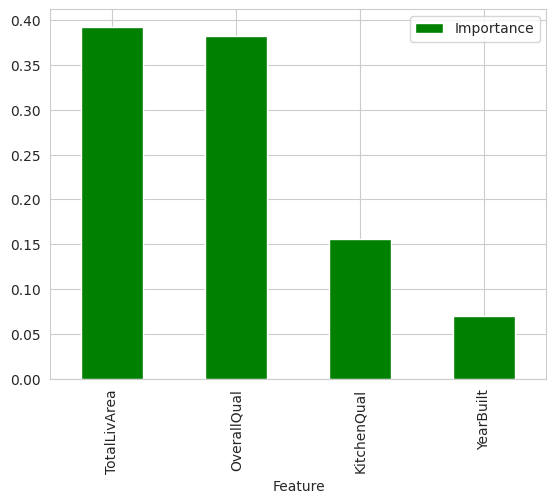

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
data_cleaning_feat_eng_steps = 13
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', color='green', x='Feature', y='Importance')
plt.show()

In [20]:
best_features

['KitchenQual', 'OverallQual', 'YearBuilt', 'TotalLivArea']

TotalLivArea is a calculated field and requires transformation from the original dataset.
The two features that are required are: ['GrLivArea','TotalBsmtSF'].

We will update best features to:

['KitchenQual', 'OverallQual', 'YearBuilt', 'GrLivArea', 'TotalBsmtSF']

Will amend the pipeline to calculate the TotalLivArea then drop the two features.

In [21]:
best_features = ['KitchenQual', 'OverallQual', 'YearBuilt', 'GrLivArea', 'TotalBsmtSF']
best_features

['KitchenQual', 'OverallQual', 'YearBuilt', 'GrLivArea', 'TotalBsmtSF']

## Evaluate on Train and Test Sets

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test,pipeline):
  """
  # Gets train/test sets and pipeline and evaluates the performance
  - for each set (train and test) call regression_evaluation()
  which will evaluate the pipeline performance
  """

  print("Model Evaluation \n")
  print("* Train Set")
  regression_evaluation(X_train,y_train,pipeline)
  print("* Test Set")
  regression_evaluation(X_test,y_test,pipeline)



def regression_evaluation(X,y,pipeline):
  """
  # Gets features and target (either from train or test set) and pipeline
  - it predicts using the pipeline and the features
  - calculates performance metrics comparing the prediction to the target
  """
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")

  

def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  """
  # Gets Train and Test set (features and target), pipeline, and adjust dots transparency 
  at scatter plot
  - It predicts on train and test set
  - It creates Actual vs Prediction scatterplots, for train and test set
  - It draws a red diagonal line. In theory, a good regressor should predict
  close to the actual, meaning the dot should be close to the diagonal red line
  The closer the dots are to the line, the better

  """
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 17107.251
Mean Squared Error: 702160770.595
Root Mean Squared Error: 26498.316


* Test Set
R2 Score: 0.797
Mean Absolute Error: 21329.206
Mean Squared Error: 1404361809.528
Root Mean Squared Error: 37474.816




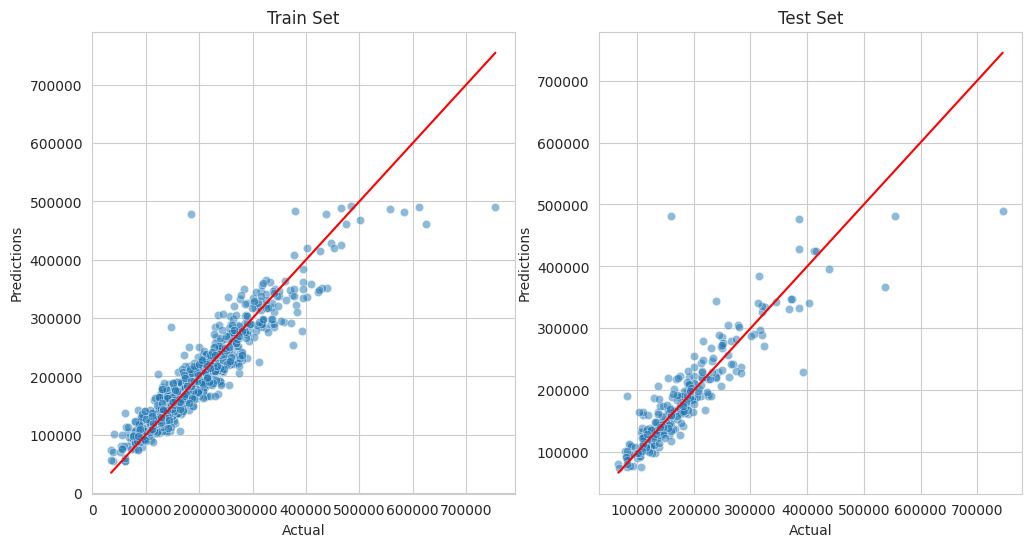

In [23]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Performance evaluation

- Both the train and test set return a R2 value which is > 0.7 as part of the business requirements
- The R2 value in the test set is lower, but within acceptable ranges.
- There may be a suggestion that the model has overfitted in the train set and futher exploration may be warrented in the future to improves the models performance on unseen data.

---

# Refit ML pipeline with best features

The following features were identifies as the best features and are to be refitted into the Pipeline - ['KitchenQual', 'OverallQual', 'YearBuilt', 'GrLivArea', 'TotalBsmtSF']

We will run the data through the pipeline which will create the 'TotalLivArea' feature and then drop the 'GrLivArea', 'TotalBsmtSF'

In [24]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from transformers import Drop_Cols_Transformer, Create_TotalLivArea_Transformer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.ensemble import ExtraTreesRegressor

# Pipeline Optmization: Model
def PipelineOptimization(model):
    pipeline = Pipeline([
        # Data cleaning
        ('create_totallivarea', Create_TotalLivArea_Transformer()),
        ('drop_columns', Drop_Cols_Transformer(columns=['GrLivArea', 'TotalBsmtSF'])),

        # Feature engineering
        ('yj', vt.YeoJohnsonTransformer(variables=['YearBuilt','TotalLivArea'])),
        ('winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=['TotalLivArea','OverallQual'])),
        
        ("scaler", StandardScaler()),
        ('model', ExtraTreesRegressor(max_features=1.0, min_samples_leaf=4, min_samples_split=10, random_state=0))
    ])

    return pipeline

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [26]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,KitchenQual,OverallQual,YearBuilt,GrLivArea,TotalBsmtSF
618,4,9,2007,1828,1822
870,3,5,1962,894,894
92,3,5,1921,964,876


In [27]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [28]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_features': 1.0,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 10,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 100}

In [29]:
models_search = {
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0),
}

params_search = {
    'ExtraTreesRegressor': {
        'model__max_depth': [None],
        'model__max_features': [1.0],
        'model__min_samples_leaf': [4],
        'model__min_samples_split': [10],
        'model__min_weight_fraction_leaf': [0.0],
        'model__n_estimators': [100],
    },
}

In [30]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [31]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__min_weight_fraction_leaf,model__n_estimators
0,ExtraTreesRegressor,0.785401,0.844095,0.877896,0.034703,None,1.0,4,10,0.0,100


In [32]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

In [33]:
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

Pipeline(steps=[('create_totallivarea', Create_TotalLivArea_Transformer()),
                ('drop_columns',
                 Drop_Cols_Transformer(columns=['GrLivArea', 'TotalBsmtSF'])),
                ('yj',
                 YeoJohnsonTransformer(variables=['YearBuilt',
                                                  'TotalLivArea'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalLivArea', 'OverallQual'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features=1.0, min_samples_leaf=4,
                                     min_samples_split=10, random_state=0))])

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 17107.251
Mean Squared Error: 702160770.595
Root Mean Squared Error: 26498.316


* Test Set
R2 Score: 0.797
Mean Absolute Error: 21329.206
Mean Squared Error: 1404361809.528
Root Mean Squared Error: 37474.816




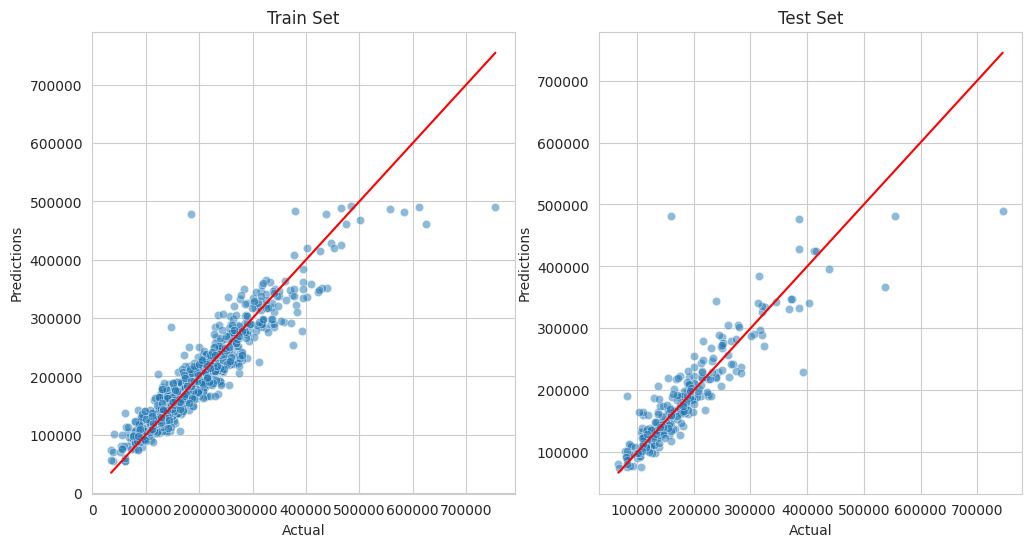

In [35]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_reg)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_reg)

### Complete pipeline after selecting best features

* These are the 4 most important features in  descending order. The model was trained on them: 
['TotalLivArea', 'OverallQual', 'KitchenQual', 'YearBuilt']


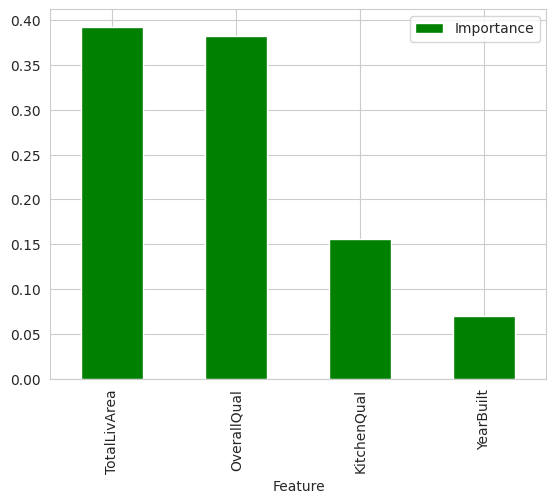

In [36]:
data_cleaning_feat_eng_steps = 4
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_reg.steps[:data_cleaning_feat_eng_steps]).transform(X_train).columns)

best_features = columns_after_data_cleaning_feat_eng

# Create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_reg['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in  "
      f"descending order. The model was trained on them: "
      f"\n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(
    kind='bar', color='green', x='Feature', y='Importance')
plt.show()

---

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [37]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_sale_price/v1'


## Train Set: features and target

In [38]:
X_train.info()
X_train.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   KitchenQual  1168 non-null   int64
 1   OverallQual  1168 non-null   int64
 2   YearBuilt    1168 non-null   int64
 3   GrLivArea    1168 non-null   int64
 4   TotalBsmtSF  1168 non-null   int64
dtypes: int64(5)
memory usage: 54.8 KB


,KitchenQual,OverallQual,YearBuilt,GrLivArea,TotalBsmtSF
618,4,9,2007,1828,1822
870,3,5,1962,894,894
92,3,5,1921,964,876


In [39]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [40]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [41]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [42]:
X_test.info()
X_test.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 529 to 61
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   KitchenQual  292 non-null    int64
 1   OverallQual  292 non-null    int64
 2   YearBuilt    292 non-null    int64
 3   GrLivArea    292 non-null    int64
 4   TotalBsmtSF  292 non-null    int64
dtypes: int64(5)
memory usage: 13.7 KB


,KitchenQual,OverallQual,YearBuilt,GrLivArea,TotalBsmtSF
529,3,6,1957,2515,2035
491,2,6,1941,1578,806
459,4,5,1950,1203,709


In [43]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [44]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [45]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling Pipeline

In [46]:
pipeline_reg

Pipeline(steps=[('create_totallivarea', Create_TotalLivArea_Transformer()),
                ('drop_columns',
                 Drop_Cols_Transformer(columns=['GrLivArea', 'TotalBsmtSF'])),
                ('yj',
                 YeoJohnsonTransformer(variables=['YearBuilt',
                                                  'TotalLivArea'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalLivArea', 'OverallQual'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features=1.0, min_samples_leaf=4,
                                     min_samples_split=10, random_state=0))])

In [47]:
joblib.dump(value=pipeline_reg, filename=f"{file_path}/predict_house_sales_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/predict_house_sales_pipeline.pkl']

## Feature Importance Plot

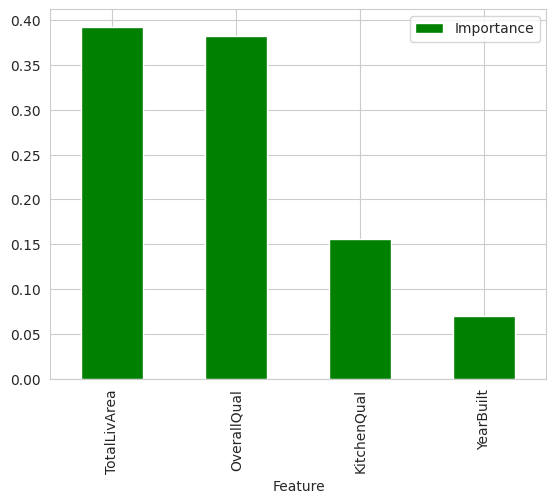

In [48]:
df_feature_importance.plot(kind='bar', color='green', x='Feature', y='Importance')
plt.show()

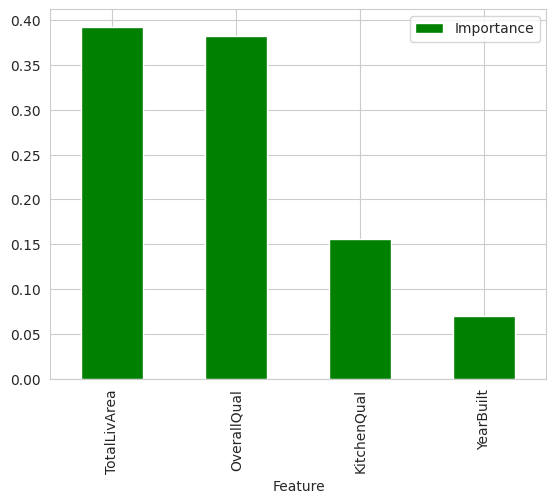

In [49]:
df_feature_importance.plot(kind='bar', color='green', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')